<a href="https://colab.research.google.com/github/Saigirish-Suryadevara/Saigirish_INFO5731_Fall2024/blob/main/Final_Project_RoBerta_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!! pip install transformers datasets scikit-learn torch pandas


['Requirement already satisfied: transformers in /usr/local/lib/python3.10/dist-packages (4.46.2)',
 'Collecting datasets',
 '  Downloading datasets-3.1.0-py3-none-any.whl.metadata (20 kB)',
 'Requirement already satisfied: scikit-learn in /usr/local/lib/python3.10/dist-packages (1.5.2)',
 'Requirement already satisfied: torch in /usr/local/lib/python3.10/dist-packages (2.5.1+cu121)',
 'Requirement already satisfied: pandas in /usr/local/lib/python3.10/dist-packages (2.2.2)',
 'Requirement already satisfied: filelock in /usr/local/lib/python3.10/dist-packages (from transformers) (3.16.1)',
 'Requirement already satisfied: huggingface-hub<1.0,>=0.23.2 in /usr/local/lib/python3.10/dist-packages (from transformers) (0.26.2)',
 'Requirement already satisfied: numpy>=1.17 in /usr/local/lib/python3.10/dist-packages (from transformers) (1.26.4)',
 'Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.10/dist-packages (from transformers) (24.2)',
 'Requirement already satis

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load data
data = pd.read_excel('/content/reddit_comments_online (3).xlsx')

# Separate labeled and unlabeled data
labeled_data = data[data['Final_label'].notna()].copy()
unlabeled_data = data[data['Final_label'].isna()].copy()

# Convert labels to integers
labeled_data['Final_label'] = labeled_data['Final_label'].astype(int)

# Split labeled data into training and validation sets
train_data, val_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

# Create Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data[['comment_body', 'Final_label']])
val_dataset = Dataset.from_pandas(val_data[['comment_body', 'Final_label']])
unlabeled_dataset = Dataset.from_pandas(unlabeled_data[['comment_body']])


In [3]:
from transformers import RobertaTokenizer

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['comment_body'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
unlabeled_dataset = unlabeled_dataset.map(tokenize_function, batched=True)

# Step 5: Map 'Final_label' to 'labels'
train_dataset = train_dataset.rename_column("Final_label", "labels")
val_dataset = val_dataset.rename_column("Final_label", "labels")

# Step 6: Format datasets for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
unlabeled_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/1199 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/3716 [00:00<?, ? examples/s]

In [4]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Updated from evaluation_strategy
    save_strategy="epoch",  # Ensure save strategy matches eval strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    save_total_limit=2,
    load_best_model_at_end=True,  # Keep this, as eval and save strategies now match
    metric_for_best_model="accuracy"
)

# Define evaluation metric
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-c6bcf10f478c>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.967424,0.633333
2,No log,0.916411,0.650000
3,No log,0.915883,0.656667


TrainOutput(global_step=225, training_loss=0.925745103624132, metrics={'train_runtime': 409.313, 'train_samples_per_second': 8.788, 'train_steps_per_second': 0.55, 'total_flos': 946444455880704.0, 'train_loss': 0.925745103624132, 'epoch': 3.0})

In [5]:
# Predict labels for the unlabeled dataset
predictions = trainer.predict(unlabeled_dataset)

# Get predicted labels
predicted_labels = predictions.predictions.argmax(axis=-1)

# Add predicted labels to the original dataset
unlabeled_data['Predicted_label'] = predicted_labels

# Save the labeled data to a new file
unlabeled_data.to_excel('posts_with_predictions.xlsx', index=False)

print("File saved to the current directory. You can download it using the file explorer on the left.")

File saved to the current directory. You can download it using the file explorer on the left.


In [6]:
!pip install matplotlib seaborn scikit-learn

<ipython-input-7-3229bc87fc58>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


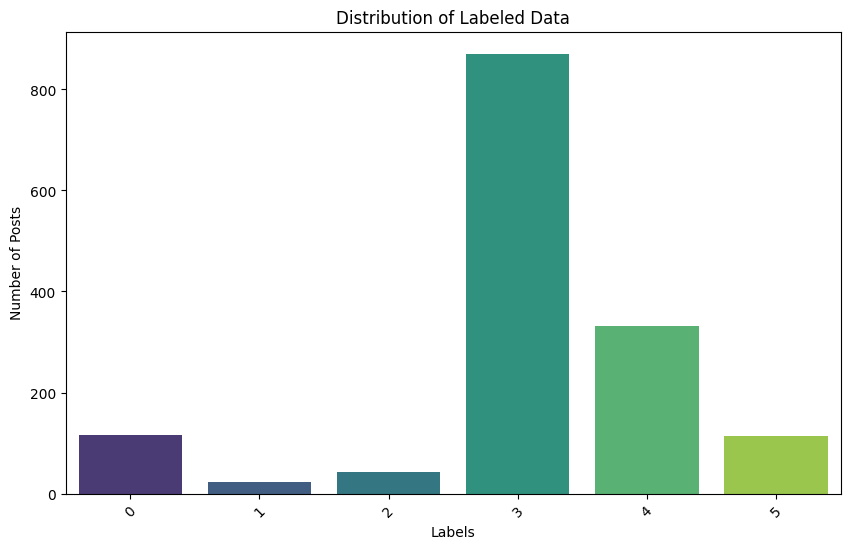

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Labeled data distribution (first 1500)
label_counts = labeled_data['Final_label'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labeled Data')
plt.xlabel('Labels')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

In [8]:
file_path = '/content/posts_with_predictions.xlsx'  # Replace with your file's name
df = pd.read_excel(file_path)

# Verify the dataset is loaded
print(df.head())

  post_id                                         post_title  post_score  \
0  lfdfer  Got my verified certificate from edX for CS50'...         167   
1  lfdfer  Got my verified certificate from edX for CS50'...         167   
2  lfdfer  Got my verified certificate from edX for CS50'...         167   
3  lfdfer  Got my verified certificate from edX for CS50'...         167   
4  lfdfer  Got my verified certificate from edX for CS50'...         167   

                              post_url Keyword_search comment_id  parent_id  \
0  https://i.redd.it/8tztigeyo9g61.jpg         python    gml477z  t3_lfdfer   
1  https://i.redd.it/8tztigeyo9g61.jpg         python    gml57dm  t3_lfdfer   
2  https://i.redd.it/8tztigeyo9g61.jpg         python    gmnlv6l  t3_lfdfer   
3  https://i.redd.it/8tztigeyo9g61.jpg         python    gmrm0gn  t3_lfdfer   
4  https://i.redd.it/8tztigeyo9g61.jpg         python    gmldlvt  t3_lfdfer   

   comment_depth                                       comment_body 

<ipython-input-9-8cb5ee8c7be5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_label_counts.index, y=predicted_label_counts.values, palette='coolwarm')


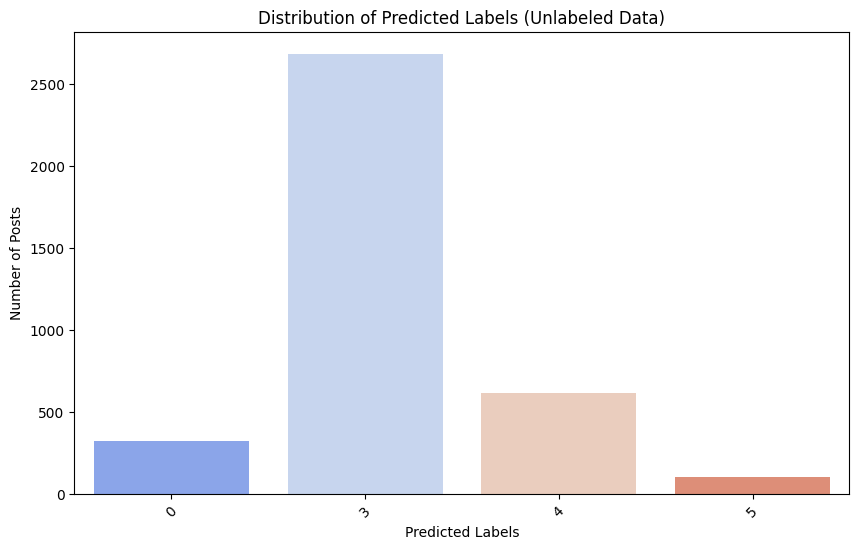

In [9]:
# Plot the distribution of predicted labels for unlabeled data
predicted_label_counts = unlabeled_data['Predicted_label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=predicted_label_counts.index, y=predicted_label_counts.values, palette='coolwarm')
plt.title('Distribution of Predicted Labels (Unlabeled Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()


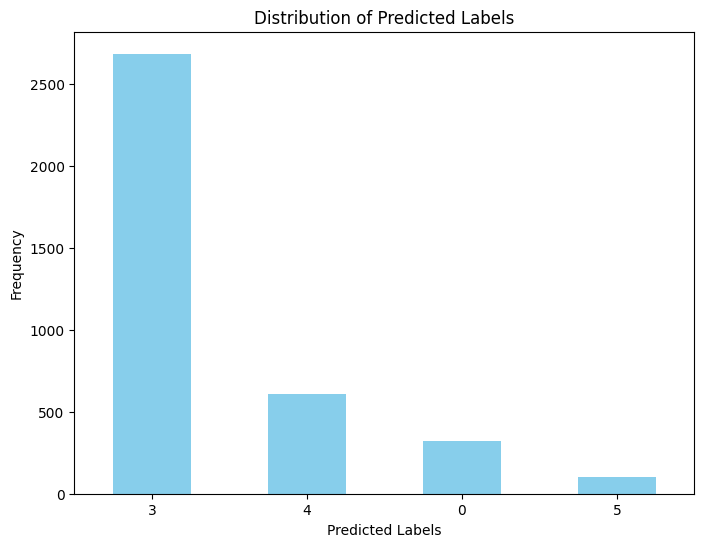

In [10]:
import pandas as pd

# Assume 'predicted_labels' is the list of predicted labels for the unlabeled data
df = pd.DataFrame(predicted_labels, columns=['Predicted_labels'])

# Plot the distribution of predicted labels
plt.figure(figsize=(8, 6))
df['Predicted_labels'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()